In [1]:
from Model3 import RiverDeltaModel
import matplotlib.pyplot as plt
import networkx as nx
import warnings 
import copy
import matplotlib.lines as mlines

c:\Users\sjuul\anaconda3\envs\afstuderen2025\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.simplefilter("ignore")

model = RiverDeltaModel()

initial_model_state = copy.deepcopy(model) 
for j in range(300):
    model.step()

There are 0 agents unassigned!!
4
5
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolleboos
wij zijn bolle

In [3]:
model_data = model.datacollector.get_model_vars_dataframe()
model_data

,Average_Livelihood,Num_household_members,Migrated_households,Migrated_members,Migrated_individuals,Died agents,Child births
0,0.302693,4496,118,370,108,200,49
1,0.321371,4216,228,700,190,301,85
2,0.318585,4002,305,927,276,395,124
3,0.324946,3864,368,1093,357,483,169
4,0.321470,3703,434,1288,408,581,198
5,0.320689,3641,487,1438,495,615,246
6,0.320789,3560,537,1591,550,649,284
7,0.319403,3463,578,1721,608,681,313
8,0.319642,3409,595,1775,650,719,344
9,0.319069,3372,607,1812,686,763,378


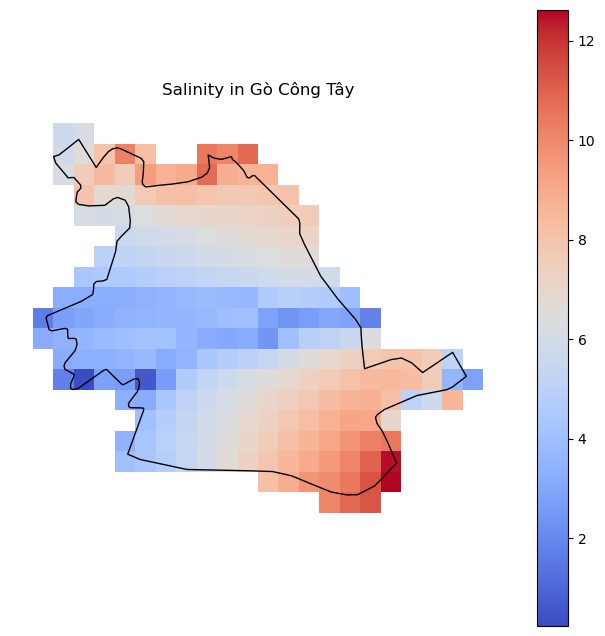

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
model.polygon_districts.boundary.plot(ax=ax, color='black', linewidth=1)
model.data_salinity.plot(ax=ax, column="Salinity", cmap="coolwarm", legend=True)
plt.title(f"Salinity in {model.district}")
plt.axis("off")
plt.show()

852
752


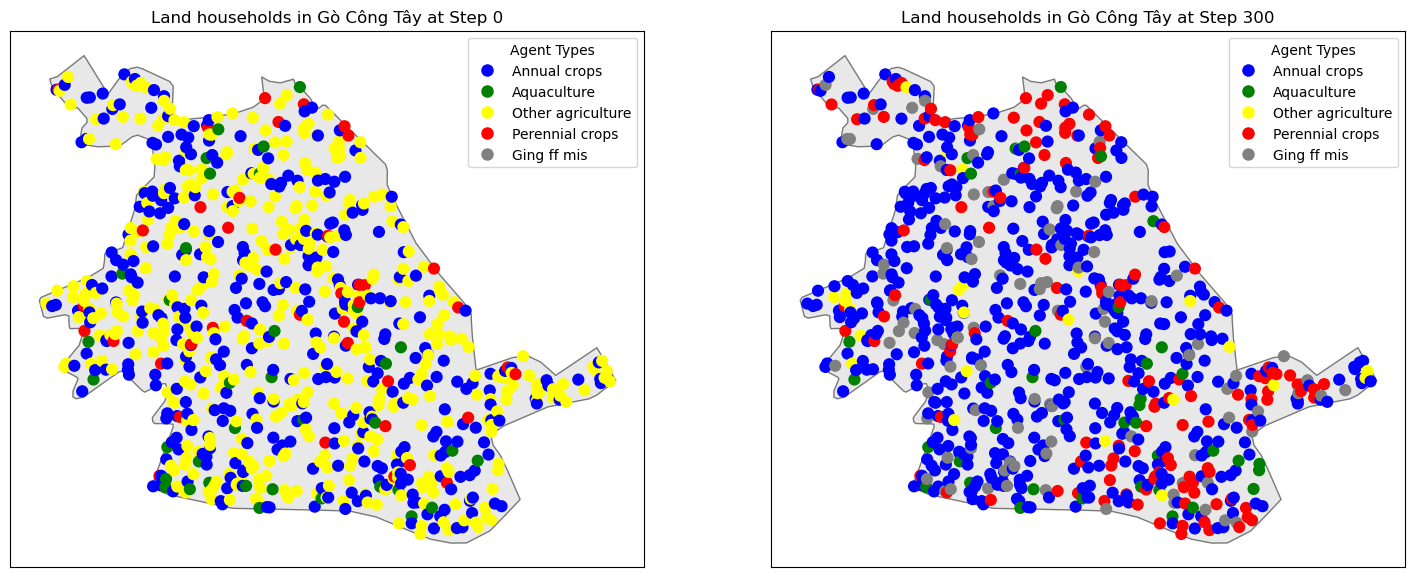

In [5]:
from Model3 import Large_land_households, Middle_land_households, Small_land_households

def plot_network(ax, model):
    ax.clear()

    # Plot district map
    model.polygon_districts.plot(ax=ax, facecolor="lightgray", edgecolor="black", alpha=0.5)

    # Get node positions
    pos = nx.get_node_attributes(model.G, 'pos')
    

    # Map node_id to agent
    node_to_agent = {agent.node_id: agent for agent in model.agents if isinstance(agent, (Large_land_households, Middle_land_households, Small_land_households))}
    print(len(node_to_agent))
    # Prepare lists for nodes and their colors
    nodes_to_draw = []
    colors_to_draw = []

    for node_id in model.G.nodes():
        nodes_to_draw.append(node_id)
        agent = node_to_agent.get(node_id)
        if agent:
            if agent.crop_type == "Annual crops":
                colors_to_draw.append('blue')
            elif agent.crop_type == "Aquaculture":
                colors_to_draw.append('green')
            elif agent.crop_type == "Other agriculture":
                colors_to_draw.append('yellow')
            elif agent.crop_type == "Perennial crops":
                colors_to_draw.append('red')
            else:
                colors_to_draw.append("gray")  # unknown crop
        else:
            colors_to_draw.append("gray")  # migrated / no agent

    # Draw edges first (optional)
    #nx.draw_networkx_edges(model.G, pos, ax=ax, edge_color="gray")

    # Draw nodes with matching colors
    nx.draw_networkx_nodes(model.G, pos,
                           nodelist=nodes_to_draw,
                           node_color=colors_to_draw,
                           node_size=60,
                           ax=ax)

    # Add legend
    blue_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Annual crops')
    green_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='green', markersize=10, label='Aquaculture')
    yellow_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Other agriculture')
    red_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='red', markersize=10, label='Perennial crops')
    grey_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Ging ff mis')
    ax.legend(handles=[blue_patch, green_patch, yellow_patch, red_patch, grey_patch], loc='upper right', title='Agent Types')

    ax.set_title(f"Land households in {model.district} at Step {model.steps}", fontsize=12)

    # Call function above to plot the map
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 9))
plot_network(ax1, initial_model_state)
plot_network(ax2, model)
plt.show()
